In [3]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Only lower-case english letters
names_text = open("../names.txt", "r").read()

words = names_text.splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
# Let's add start/end special symbol '.' for each word
words = ["." + word + "." for word in words]
words[:5]

# Later when we train the model based on frequency, it'll be useful to know
# what is a popular way to start and end a word

# For example '.' -> 'a' is popular because there are a lot of names starting with 'a'
# and         'n' -> '.' is popular because there are a lot of names ending with 'n'

['.emma.', '.olivia.', '.ava.', '.isabella.', '.sophia.']

In [ ]:
# Let's count frequencies
def stoi(c):    
    if c == '.':
        return 0
    return ord(c) - ord('a') + 1

def itos(i):
    if i == 0:
        return '.'
    return chr(i + ord('a') - 1)


# Counting frequencies
# freq[0][1] = how many times '.' is followed by 'a'
N = torch.zeros(27, 27, dtype=torch.int32)
for w in words:
    for c, c_next in zip(w, w[1:]):
        N[stoi(c), stoi(c_next)] += 1

# Plotting the matrix
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for row in range(27):
    for col in range(27):
        chstr = itos(row) + itos(col)
        plt.text(col, row, chstr, ha='center', va='bottom', color='gray')
        plt.text(col, row, f'{N[row, col]:.0f}', ha='center', va='top', color='gray')
plt.show()

In [ ]:
# I know that torch.multinomial doesn't need the probabilities to sum to 1
# https://pytorch.org/docs/stable/generated/torch.multinomial.html
# but let's normalize data because it's a good practice!

# We have a matrix of frequencies N and we want to calculate matrix of probabilities.
# We want to divide each row by the sum of the row.
P = N.float() / N.sum(dim=1, keepdim=True).float()

""" How do we do it? - step by step:
1. Compute 27x1 tensor with sums of rows using N.sum(dim=1, keepdim=True)
   dim=1 means that we "get rid off" dimension 1 (columns) while summing
   keepdim=True means that we keep the dimension 1 in the resulting tensor,
   by default it would be squeezed out.

2. Copy 27x1 tensor 27 times to get 27x27 tensor

3. Now we can divide tensors cell-by-cell.

The copy operation is called broadcasting. It's a powerful mechanism that allows PyTorch to work with arrays of different shapes.
Two tensors are “broadcastable” if the following rules hold:
* Each tensor has at least one dimension.
* When iterating over the dimension sizes, starting at the trailing dimension, 
  the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

For example we can add 3x4 tensor to 1x4 tensor because 3 and 1 are compatible.
But we can't add 3x4 tensor to 3x3 tensor because 4 and 3 are not compatible.

More about broadcasting: https://pytorch.org/docs/stable/notes/broadcasting.html 

Warning!!! Broadcasting is a powerful mechanism but it can be a source of bugs. For example:
* N / N.sum(dim=1, keepdim=False) - bug, gives [27] shaped tensor so broadcasting copies rows instead of columns
* N / N.sum(dim=1, keepdim=True) - correct!, gives [27, 1] shaped tensor, broadcasting copies columns"""

' How do we do it? - step by step:\n1. Compute 27x1 tensor with sums of rows using N.sum(dim=1, keepdim=True)\n   dim=1 means that we "get rid off" dimension 1 (columns) while summing\n   keepdim=True means that we keep the dimension 1 in the resulting tensor,\n   by default it would be squeezed out.\n\n2. Copy 27x1 tensor 27 times to get 27x27 tensor\n\n3. Now we can divide tensors cell-by-cell.\n\nThe copy operation is called broadcasting. It\'s a powerful mechanism that allows PyTorch to work with arrays of different shapes.\nTwo tensors are “broadcastable” if the following rules hold:\n* Each tensor has at least one dimension.\n* When iterating over the dimension sizes, starting at the trailing dimension, \n  the dimension sizes must either be equal, one of them is 1, or one of them does not exist.\n\nFor example we can add 3x4 tensor to 1x4 tensor because 3 and 1 are compatible.\nBut we can\'t add 3x4 tensor to 3x3 tensor because 4 and 3 are not compatible.\n\nMore about broadcast

In [ ]:
def generate_name_stochastically(probabilities: torch.Tensor) -> str:
    """
    Generate a random name based on character transition frequencies.
    Returns a name string with start/end markers removed.
    """
    name = []
    idx = 0     # index of the start character
    while True:
        # Sample the next character based on frequency distribution
        p = probabilities[idx]
        idx = torch.multinomial(p, 1).item()

        # Add the new character to our name
        if idx != 0:
            name.append(itos(idx))

        # If we hit the end marker and desired length, we're done
        elif len(name) >= 3:
            break

    return "".join(name)


# Generate a few names
for _ in range(5):
    print(generate_name_stochastically(P))

hysharandaynnamarieryn
alonn
feyl
rmide
briae


In [ ]:
# GOAL: maximize likelihood of th data w.r.t. the model parameters (statistical modeling)
# equivalent to maximizing the log-likelihood (log is a monotonic, increasing function)
# equivalent to minimizing the negative log-likelihood (NLL)
# equivalent to minimizing the mean negative log-likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

def compute_loss(probs: torch.Tensor, ys: torch.Tensor) -> torch.Tensor:
    """
    Compute the mean negative log-likelihood of a sequence of characters given the transition probabilities.
    Add L2 regularization to the loss.

    Args:
    - probs: a tensor of shape (27, 27) containing transition probabilities
    - ys: a tensor of shape (N,) containing character indices. for example:
    ys = torch.tensor([0, 1, 2, 3, 0]) corresponds to the sequence '.abcd.'
    """
    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    l2_loss = (probs**2).mean() * 0.1  # L2 regularization
    return loss + l2_loss


ys = torch.tensor([stoi(c) for c in ".andrejq."])
compute_loss(P, ys)

tensor(inf)

In [ ]:
# We don't want to have inf in the loss function, so we add a small number to the frequency matrix
# it's called Laplace smoothing: https://en.wikipedia.org/wiki/Additive_smoothing
P = N.float() + 1.0
P /= P.sum(dim=1, keepdim=True)

compute_loss(P, ys)

tensor(5.4629)

In [ ]:
# Let's split the data into features and labels
xs, ys = [], []
for w in words:
    for c, c_next in zip(w, w[1:]):
        xs.append(stoi(c))
        ys.append(stoi(c_next))

xs, ys = torch.tensor(xs), torch.tensor(ys)

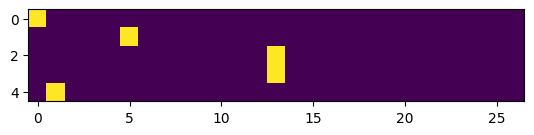

In [ ]:
# Let's create MultiLayerPerceptron model
# but how do we encode the input? - one-hot encoding
# https://en.wikipedia.org/wiki/One-hot

# https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
plt.imshow(xenc[:5])

In [ ]:
# Randomly initialize the weights of the model
W = torch.randn((27, 27), requires_grad=True)

def softmax(x):
    """Normalizes values to a probability distribution using softmax function.
    
    It's a good way to normalize because:
    - the function is monotonic so it doesn't change the order of values
    - all values are positive due to exponentiation
    - the sum of values is 1 due to normalization
    - the function is differentiable so we can use it in backpropagation"""
    return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [ ]:
# Forward pass
logits = xenc @ W
probs = softmax(logits)
loss = compute_loss(probs, ys)
loss.item()

3.7578442096710205

In [ ]:
# Backward pass
W.grad = None           # clear the gradients
loss.backward()         # compute 
W.data -= 0.1 * W.grad  # update the weights